In [ ]:
ei.trash

In [41]:
import os
import time
import datetime
import subprocess
import glob
from urllib.parse import urlparse
from PIL.PngImagePlugin import PngInfo
from PIL import Image

import qtawesome as qta
from PyQt5.QtWidgets import *
from PyQt5.QtGui import QPixmap,QColor,QFont,QImage,QIcon
from PyQt5.QtCore import Qt,pyqtSignal,QPoint,QSize,QTimer
import numpy as np
import pandas as pd
import cv2
from PIL import Image
#import imagehash
from Levenshtein import distance as lev_distance
from __future__ import print_function
import argparse
import rembg
from Othumbnails import ThumbnailMaker
from custom import *
from styles import *
os.environ['QT_QPA_PLATFORM_PLUGIN_PATH'] = '/path/to/your/qt/plugins'
from PyQt5.QtCore import pyqtSlot
classesNames=['bicycle','boat','building','bus','car','forest',
             'glacier','helicopter','motorcycle', 'mountain',
             'plane','sea','street','train','truck','cat']




class MainWidget(QWidget):
    def __init__(self):
        super().__init__()

        self.init_ui()
    def init_ui(self):
        self.setWindowTitle('OGallery')
        self.setGeometry(300, 100, 800, 650)
        self.style=OStyle()
        icon = qta.icon('fa5s.map-pin',color='#212121',scale_factor=1.2)
        self.setWindowIcon(icon)
       
        #buttons instantiation
        self.query = QLineEdit(self)
        self.search_button = QPushButton('➤', self)
        self.info_button=QPushButton()
        self.settings_button=QPushButton()
        self.gallery_button=QPushButton()
       
        #Autocomplete using QCompleter
        completer = QCompleter(classesNames, self)
        completer.setCaseSensitivity(Qt.CaseInsensitive)
        self.query.setCompleter(completer)
        
        #logo QLabel instantiation and settings
        self.logo_label = QLabel(self)
        pixmap = QPixmap('logo.jpg')
        self.logo_label.setPixmap(pixmap)
        self.logo_label.setAlignment(Qt.AlignCenter)
        
        #layout structure 
        layout = QVBoxLayout(self)
        horizontal_layout = QHBoxLayout()
        header_layout=QHBoxLayout()
        
        header_layout.addWidget(self.settings_button)
        header_layout.addWidget(self.gallery_button)
        header_layout.addStretch(1)
        header_layout.addWidget(self.info_button)
                
        layout.addLayout(header_layout)
        layout.addWidget(self.logo_label)
                
        horizontal_layout.addWidget(self.query)
        horizontal_layout.addWidget(self.search_button)
        layout.addLayout(horizontal_layout)
        layout.addStretch(1)
        
        #connect button signals to their respective functions
        self.search_button.clicked.connect(self.openImageViewer)
        self.info_button.clicked.connect(self.showAppInfo)
        self.gallery_button.clicked.connect(self.openGallery)
        # Elements font
        font = QFont()
        font.setPointSize(16)        
        self.search_button.setFont(font)
        
        
        #Elements style
        self.setStyleSheet(f"background-color: {self.style.color.background};color:white;")
        self.query.setFixedHeight(33)
        self.search_button.setFixedSize(36, 36) 
        self.info_button.setFixedWidth(45)
        self.settings_button.setFixedSize(45,45)

        button_style = f"QPushButton {{ background-color: {self.style.color.background}; \
                                        color: white; \
                                        border: 2px solid #2e2e2e; \
                                        border-radius: 18px;padding: 5px;}} \
                                        QPushButton:hover {{  \
                                        background-color: {self.style.color.hover_default}; }}"
        
        header_buttons_style = f"QPushButton {{ background-color: {self.style.color.background}; \
                                        color: #999999; \
                                        icon-size: {self.style.size.standard_icon_size}; \
                                        border: 2px solid {self.style.color.background}; \
                                        border-radius: 18px;padding: 5px;}} \
                                        QPushButton:hover {{  \
                                        background-color: {self.style.color.hover_default}; }}"
        
        qline_style = (
            f"QLineEdit {{ \
             background-color: {self.style.color.background}; \
             color: white; \
             border-radius: 15px; \
             padding: 5px; \
             border: 2px solid {self.style.color.light_gray}; \
             font-size: 12pt; \
             }}"
        )
        
        self.search_button.setStyleSheet(button_style) 
        self.info_button.setStyleSheet(header_buttons_style)
        self.settings_button.setStyleSheet(header_buttons_style)   
        self.gallery_button.setStyleSheet(header_buttons_style)
        self.query.setStyleSheet(qline_style)
        completer.popup().setStyleSheet(f"background-color: {self.style.color.light_gray}; \
                                        color: white; \
                                        font-size: 12pt;")

        
        #icons
        info_icon=qta.icon('ei.info-circle',color='#999999')
        self.info_button.setIcon(info_icon)
        settings_icon=qta.icon('fa.cog',color='#999999')
        self.settings_button.setIcon(settings_icon)

        gallery_icon=qta.icon('mdi.folder-image',color='#999999')
        self.gallery_button.setIcon(gallery_icon)
        
        self.show()

    def openImageViewer(self):
        self.selectImages()
            
        if self.result:
            self.viewer = ImageViewer(self.result, self)
            self.viewer.finishedSignal.connect(self.showMainWidget)
            self.viewer.show()
            self.hide()
        
    def openGallery(self):
        self.image_gallery=ImageGalleryApp()
        self.image_gallery.show()
    def showMainWidget(self):
        """
        Show the main widget when the ImageViewer is closed
        Args:
            None
        Returns:
            None
        """
        self.show()
        
        
    def selectImages(self):
        self.queryText=self.query.text()
        self.queryText=self.suggestClasses(self.queryText)
        if self.queryText==None:
            self.showErrorMessage("No images found")
            
        db=pd.read_csv("log.csv")
        self.result=db[db["class"]==self.queryText]["directory"].to_list()
                
    
    
    def suggestClasses(self,query):
        '''
        find the levenshtein distance between existing classes and 
        the search query and returns the classes with distance <= 2
        Args:
            query (str)
        Returns: 
            suggested class (str) or None
        '''
        classes=['plane','car','cat','dog','food','sea','documents']
        query=query.lower()
        
        #check for exact match
        if query in classes:
            return query
        #check for lev distance of 1 with avg words length
        for classi in classes:
            if lev_distance(query,classi)==1:
                return classi
        
        #check for lev distance of 2 with long words i.e >=8
        for classi in list(filter(lambda x: len(x) >= 8, classes)):
            if lev_distance(query,classi)==2:
                return classi
        
        #No matches returned.
        return None
    
    
    def keyPressEvent(self, event):
        """
        Event handler for key press events, overriding the base class method.

        Args:
            event (QKeyEvent): The key event object containing information about the key press.

        Returns:
            None
        """
        
        if (event.key() == Qt.Key_Return) or (event.key() == Qt.Key_Enter):
            self.openImageViewer()
            
    def showErrorMessage(self,msg):
        """
        Displays a QMessageBox warning
        Args:
            msg (str)
        Returns:
            None
        """
        msg_box = InfoMessageBox()
        #error_icon=qta.icon('mdi.robot',color='#bfa708')
        pixmap1 = QPixmap(qta.icon('mdi.jellyfish',color='#faf7f7').pixmap(100,100))
        pixmap2 = QPixmap(qta.icon('fa.exclamation',color='#fde01a').pixmap(50,50))
        combined_pixmap = CustomAwesome().concat_pixmaps(pixmap1, pixmap2,1.5)
        msg_box.setIconPixmap(combined_pixmap)
        msg_box.setText(msg)
        msg_box.setWindowTitle('Warning')
        msg_box.exec_()
        
    def showAppInfo(self):
        """
        Displays a QMessageBox containing application information such as maintainers 
        and supported classes
        
        Args:
            None
        Returns:
            None
        """
        msg_box = InfoMessageBox()
        #msg_info_icon=qta.icon('fa.space-shuttle',color='white')
        pixmap1 = QPixmap(qta.icon('mdi.jellyfish',color='#faf7f7').pixmap(100,100))
        pixmap2 = QPixmap(qta.icon('mdi.glasses',color='#000000').pixmap(50,50))
        
        msg_box.setIconPixmap(CustomAwesome().concat_pixmaps(pixmap1, pixmap2,3))
        msg_box.setText(f"This application is created and maintained by \
Mahmoud gamal \
        current supported search classes are {', '.join(classesNames)}")
        msg_box.setWindowTitle('info')
        msg_box.exec_()

class ImageViewer(QWidget):
    finishedSignal = pyqtSignal()
    def __init__(self, result, main_widget,current_index=0,from_gallery=False):
        super().__init__()
        self.from_gallery=from_gallery
        self.style=OStyle()
        self.file_list = []
        self.current_index = current_index
        self.exposure_state=1
        self.primary_screen = QDesktopWidget().screenGeometry()
        self.screen_width = self.primary_screen.width()
        self.screen_height = self.primary_screen.height()
        self.result = result
        self.edit_history=[]
        self.main_widget = main_widget  
        self.init_ui()

    def init_ui(self):
        self.setWindowTitle('Image Viewer')
        self.setGeometry(300, 100, 750, 550)
        
        self.image_view = QGraphicsView(self)
        self.image_view.setAlignment(Qt.AlignCenter)
        self.image_view.setHorizontalScrollBarPolicy(Qt.ScrollBarAlwaysOff)
        self.image_view.setVerticalScrollBarPolicy(Qt.ScrollBarAlwaysOff)
        
        self.scene = QGraphicsScene()
        self.image_view.setScene(self.scene)
        
        # this is to fix weird behaviour similar to stackoverflow Q #68182395
        QTimer.singleShot(0, self.handle_timeout)
        self.image_view.wheelEvent = self.zoom_image

        
        self.keylist = []
        self.file_list = []
        #self.current_index = 0
        self.setMouseTracking(True)
        self.load_images()

        # Main layout using QVBoxLayout
        layout = QVBoxLayout(self)
        Hlayout=QHBoxLayout(self)
        header_layout=QHBoxLayout()
        editing_buttons_layout = QHBoxLayout(self)

       
        self.leftBrowse = QPushButton('〈', self)
        self.rightBrowse = QPushButton('〉', self)
        self.back_button = QPushButton('↩', self)
        
        #SCF_icon = qta.icon("fa5s.search-location",color="white")  # Use the correct icon name here
        SCF_icon = qta.icon("mdi.folder-search-outline",color="white")  # Use the correct icon name here
        
        self.show_containing_folder_button=QPushButton(SCF_icon,'')
        self.show_containing_folder_button.setIconSize(SCF_icon.actualSize(QSize(20,  20)))  # Set the size of the icon
        Hlayout.addWidget(self.leftBrowse)
        Hlayout.addWidget(self.image_view)
        Hlayout.addWidget(self.rightBrowse)

        header_layout.addWidget(self.back_button)
        header_layout.addStretch(1)
        header_layout.addWidget(self.show_containing_folder_button)
        
        self.sharpen_button = QPushButton()
        self.gray_button = QPushButton()
        self.gaussianBlur_button = QPushButton()
        self.rotate_button = QPushButton()
        self.flip_button=QPushButton()
        self.set_exposure_button = QPushButton()
        self.blur_background_button = QPushButton()
        self.undo_button=QPushButton()
        self.compare_button=QPushButton()
        self.revert_button = QPushButton('Revert', self)
        
        self.save_button = QPushButton()
        
        #setting icons       
        self.save_button.setIcon(qta.icon('fa5.save', color='white'))
        self.undo_button.setIcon(qta.icon('mdi.undo-variant', color='white'))
        self.rotate_button.setIcon(qta.icon('mdi.crop-rotate', color='white'))
        self.gray_button.setIcon(qta.icon('mdi.image-filter-black-white',color='white'))
        self.gaussianBlur_button.setIcon(qta.icon('mdi.blur',color='white'))
        self.blur_background_button.setIcon(qta.icon('fa.user',color='white'))
        self.sharpen_button.setIcon(qta.icon('mdi.details',color='white'))
        self.set_exposure_button.setIcon(qta.icon('mdi.camera-iris',color='white'))
        self.flip_button.setIcon(qta.icon('mdi.reflect-horizontal',color='white'))
        self.compare_button.setIcon(qta.icon('mdi.select-compare',color='white'))
        
       
        #tooltip
        self.rotate_button.setToolTip('Rotate')
        self.undo_button.setToolTip('Undo')
        self.gray_button.setToolTip('Gray scale')
        self.gaussianBlur_button.setToolTip('Blur')
        self.blur_background_button.setToolTip('Portrait')
        self.flip_button.setToolTip('Flip horizontally')
        self.sharpen_button.setToolTip('Sharpen')
        self.set_exposure_button.setToolTip('Exposure')
        self.show_containing_folder_button.setToolTip('Show containing folder')
        
        self.exposure_slider = QSlider(Qt.Horizontal)
        self.exposure_slider.setMinimum(0)
        self.exposure_slider.setMaximum(200)
        self.exposure_slider.setValue(100)  # Set an initial value
        self.exposure_slider.valueChanged.connect(self.update_exposure)
        self.exposure_slider.hide()
        
        
        editing_buttons=[self.sharpen_button,self.gray_button,
                self.gaussianBlur_button,self.rotate_button,self.flip_button,self.set_exposure_button ,
                 self.blur_background_button,self.compare_button, self.revert_button,self.undo_button,self.save_button
                ]
        navigation_buttons=[self.leftBrowse,self.rightBrowse ,self.back_button,self.show_containing_folder_button]
        
        #setting focus policy for all buttons
        for button in editing_buttons+navigation_buttons:
            button.setFocusPolicy(Qt.NoFocus)

        
        self.image_view.setFocusPolicy(Qt.NoFocus)
        #adding editing buttons to th editing buttons layout2+++++++
        for  button in editing_buttons:
            button.setFixedHeight(40)

            editing_buttons_layout.addWidget(button)
   
        layout.addLayout(header_layout)
        layout.addLayout(Hlayout)
        layout.addWidget(self.exposure_slider)
        layout.addLayout(editing_buttons_layout)
        self.setLayout(layout)

        # Connect button signals to their respective functions
        
        self.sharpen_button.clicked.connect(self.sharpen_image)
        self.gray_button.clicked.connect(self.BGR2GRAY)
        self.gaussianBlur_button.clicked.connect(self.gaussianBlur)
        self.rotate_button.clicked.connect(self.rotateCCW)
        self.flip_button.clicked.connect(self.flipH)
        self.set_exposure_button.clicked.connect(self.toggle_exposure_slider)
        self.save_button.clicked.connect(self.save_image)
        self.back_button.clicked.connect(self.goHome)
        self.blur_background_button.clicked.connect(self.blurBackground)
        self.undo_button.clicked.connect(self.undo)
        self.revert_button.clicked.connect(self.revert)
        self.leftBrowse.clicked.connect(self.next_image)
        self.rightBrowse.clicked.connect(self.previous_image)
        self.show_containing_folder_button.clicked.connect(self.show_containing_folder)
        self.compare_button.pressed.connect(self.show_image)
        self.compare_button.released.connect(self.show_edited_image)
        
        ###############################
        
        self.rightBrowse.enterEvent = self.on_enter_event
        self.rightBrowse.leaveEvent = self.on_leave_event
        self.leftBrowse.enterEvent = self.on_enter_event
        self.leftBrowse.leaveEvent = self.on_leave_event
      
        #Setting styles
        self.setStyleSheet(f"background-color: {self.style.color.background};")
        self.leftBrowse.setFont(self.style.size.large_font)
        self.rightBrowse.setFont(self.style.size.large_font)
        border_color='#242424'
        
        button_style = ("QPushButton {{"
                "background-color: #1f1f1f; "
                "color: white; "
                "icon-size:{icon_size};"
                "border-top: 2px solid {border_color}; "
                "border-bottom: 2px solid {border_color}; "
                "border-right: 2px solid {border_color}; "
                "border-left: 2px solid {border_color}; "
                "}} "
                "QPushButton:hover {{"
                "background-color: #00347d; "
                "}}").format(border_color=border_color,icon_size=self.style.size.standard_icon_size)

        
        
        for button in editing_buttons:
            button.setStyleSheet(button_style)
        
        
        
        header_buttons_style=(
            "QPushButton {background-color: rgba(22, 22, 22, .5); \
            border: none; \
            color: white; \
            font-size: 16pt;} \
            QPushButton:hover {background-color: #2e2e2e;} "
        )
        self.back_button.setStyleSheet(header_buttons_style)
        self.show_containing_folder_button.setStyleSheet(header_buttons_style)
        
        self.back_button.setFixedSize(60,40) 
        self.show_containing_folder_button.setFixedSize(60,40)
        self.leftBrowse.setFixedSize(60, self.height())
        self.rightBrowse.setFixedSize(60, self.height())

        browsing_buttons_style= "background-color: rgba(22, 22, 22, .5); \
                                                    color: white; \
                                                    border: none;"
        self.leftBrowse.setStyleSheet(browsing_buttons_style)
        self.rightBrowse.setStyleSheet(browsing_buttons_style)

        self.image_view.setStyleSheet("border: none;")
        
        
        
        self.set_transparency(0)
        self.load_images()
        self.show_image()
        self.show()
      

    def load_images(self):
        self.file_list = self.result
        
    def show_image(self):
        if self.file_list:
            image_path = self.file_list[self.current_index]
            pixmap = QPixmap(image_path)

            # Clear the scene before adding a new item
            self.scene.clear()

            # Add a QGraphicsPixmapItem to the scene
            pixmap_item = QGraphicsPixmapItem(pixmap)
            self.scene.addItem(pixmap_item)

        
            
            # Set the scene rect to match the pixmap size
            self.scene.setSceneRect(pixmap_item.boundingRect())

            # Fit the image to the view
            self.image_view.fitInView(pixmap_item, Qt.KeepAspectRatio)


            self.setWindowTitle(f'Image Viewer - {os.path.basename(image_path)}')



    def show_edited_image(self):
        self.scene.clear()
        pixmap = QPixmap(self.convert_cv_image_to_qpixmap(self.edited_image))

        # Clear the scene before adding a new item
        #

        # Add a QGraphicsPixmapItem to the scene
        pixmap_item = QGraphicsPixmapItem(pixmap)
        self.scene.addItem(pixmap_item)

        # Set the scene rect to match the pixmap size
        self.scene.setSceneRect(pixmap_item.boundingRect())

        # Fit the image to the view
        self.image_view.fitInView(pixmap_item, Qt.KeepAspectRatio)

        
    def handle_timeout(self):
        if self.file_list:
            image_path = self.file_list[self.current_index]
            pixmap = QPixmap(image_path)
            pixmap_item = QGraphicsPixmapItem(pixmap)

            self.image_view.fitInView(pixmap_item, Qt.KeepAspectRatio)
        
    def zoom_image(self, event):
        # Get the current transformation matrix of the view
        transform = self.image_view.transform()

        # Set the transformation anchor to the center of the view
        self.image_view.setTransformationAnchor(QGraphicsView.AnchorUnderMouse)

        # Get the zoom factor
        delta = event.angleDelta().y() / 120  # Get the scroll steps (typically 120 per step)
        zoom_factor = 1.1 if delta > 0 else 0.9  # Define the zoom factor

        # Scale the view using zoom_factor
        transform.scale(zoom_factor, zoom_factor)

        # Apply the new transformation to the view
        self.image_view.setTransform(transform)


    def keyPressEvent(self, event):
        
        #Navigating images in the directory
        if event.key() == Qt.Key_Right:
            self.next_image()
        elif event.key() == Qt.Key_Left:
            self.previous_image()
    
        if (event.key() == Qt.Key_Backspace) or (event.key() == Qt.Key_Escape):
            self.goHome()
        
        if event.key()==Qt.Key_Delete:
            self.delete_image()
        #saving edited images using key event ctrl&s
        if event.key()== Qt.Key_Control:
            self.keylist.append(Qt.Key_Control)
            print(self.keylist)#to be deleted later
            
        if event.key()==Qt.Key_S :
            self.keylist.append(Qt.Key_S)
            print(self.keylist)#to be deleted later
        
        if len(self.keylist)==2:
            if (self.keylist[0]*self.keylist[1])==Qt.Key_Control*Qt.Key_S:
                self.save_image()
         
        
    
    def keyReleaseEvent(self, event):
        time.sleep(.2)
        self.keylist=[] #clear keylist
        
    def next_image(self):
        self.current_index = (self.current_index + 1) % len(self.file_list)
        self.show_image()

    def previous_image(self):
        self.current_index = (self.current_index - 1) % len(self.file_list)
        self.show_image()
        
    
    def set_transparency(self, alpha):
        self.rightBrowse.setStyleSheet(f"background-color: rgba(22,22,22,{alpha});border: none;color: rgba(255,255,255,{alpha});")
        self.leftBrowse.setStyleSheet(f"background-color: rgba(22,22,22,{alpha});border: none;color: rgba(255,255,255,{alpha});")

    def on_enter_event(self, event):
        # Set transparency when mouse enters
        self.set_transparency(.5)

    def on_leave_event(self, event):
        # Set transparency back to normal when mouse leaves
        self.set_transparency(0)
        
    def sharpen_image(self):
            if hasattr(self, 'edited_image'):
                img=self.edited_image
            else :
                image_path = self.file_list[self.current_index]
                img = cv2.imread(image_path)
            
            gaussian_blurred=cv2.GaussianBlur(img,(5,5),1)
            sharpened=cv2.addWeighted(img,1.5,gaussian_blurred,-.5,0)
            self.edited_image=sharpened
            self.edit_history.append(self.edited_image)
            self.show_edited_image()
    def  BGR2GRAY(self):
        if hasattr(self, 'edited_image'):
            img=self.edited_image
        else :
            image_path = self.file_list[self.current_index]
            img = cv2.imread(image_path)
        
        gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        gray_3C=cv2.merge([gray,gray,gray])
        self.edited_image=gray_3C
        self.edit_history.append(self.edited_image)
        self.show_edited_image()
        
        
    def gaussianBlur(self):
        if hasattr(self, 'edited_image'):
            img=self.edited_image
        else :
            image_path = self.file_list[self.current_index]
            img = cv2.imread(image_path)
        
        Blurred_img=cv2.GaussianBlur(img,ksize=(3,3),sigmaX=1)
        self.edited_image=Blurred_img
        self.edit_history.append(self.edited_image)
        self.show_edited_image()
        
        
    def rotateCCW(self):
        if hasattr(self, 'edited_image'):
            img=self.edited_image
        else :
            image_path = self.file_list[self.current_index]
            img = cv2.imread(image_path)
        
        rotatedImg=cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        self.edited_image=rotatedImg
        self.edit_history.append(self.edited_image)
        self.show_edited_image()
        
    def flipH(self):
        if hasattr(self, 'edited_image'):
            img=self.edited_image
        else :
            image_path = self.file_list[self.current_index]
            img = cv2.imread(image_path)
        
        flipped_img=cv2.flip(img, 1)
        self.edited_image=flipped_img
        self.edit_history.append(self.edited_image)
        self.show_edited_image()
    
    def toggle_exposure_slider(self):
    # Toggle the visibility of the slider when the button is pressed
        self.exposure_slider.setVisible(not self.exposure_slider.isVisible())
        colors=['#1f1f1f','#00347d']
        border_color='#242424'
        self.exposure_state=not self.exposure_state
        exposure_button_style=f"QPushButton {{ background-color: {colors[not self.exposure_state]}; color: white;border-top: 2px solid {border_color};border-bottom: 2px solid {border_color};border-right: 2px solid {border_color}; border-left: 2px solid {border_color};}}"
        self.set_exposure_button.setStyleSheet(exposure_button_style)
    def update_exposure(self, gamma1e2):

        image_path = self.file_list[self.current_index]
        img = cv2.imread(image_path)
        gamma=gamma1e2/100
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
            for i in np.arange(0, 256)]).astype("uint8")
        exposureImg= cv2.LUT(img, table)
        self.edited_image=exposureImg
        self.edit_history.append(self.edited_image)
        self.show_edited_image()
    
    def blurBackground(self):
        if hasattr(self, 'edited_image'):
            img=self.edited_image
        else :
            image_path = self.file_list[self.current_index]
            img = cv2.imread(image_path)
        mask = rembg.remove(img,only_mask=True)
        mask_3c=cv2.merge([mask,mask,mask])
        inv_mask_3c=255-np.copy(mask_3c)
        foreground=cv2.bitwise_and(img,mask_3c)
        background=cv2.bitwise_and(img,inv_mask_3c)
        blurred_background=cv2.blur(background,(9,9))
        blurred_bg_image=foreground+blurred_background
        self.edited_image=blurred_bg_image
        self.show_edited_image()
        
    def convert_cv_image_to_qpixmap(self, cv_image):
            cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
            height, width, channel = cv_image.shape
            bytes_per_line = 3 * width
            q_image = QImage(cv_image.data, width, height, bytes_per_line, QImage.Format_RGB888)
            return QPixmap.fromImage(q_image)


        
        
    def undo(self):
        if len(self.edit_history)>1:
            
            self.edit_history.pop()  
            self.edited_image=self.edit_history[-1]
            self.show_edited_image()
            

        else:
            if hasattr(self, 'edited_image'):
                self.edit_history=[]
                delattr(self,'edited_image')
                self.show_image()
            
            
    def revert(self):
        if hasattr(self, 'edited_image'):
            delattr(self,'edited_image')
            self.edit_history=[]
        self.show_image()
    
    def save_image(self):
        if hasattr(self, 'edited_image'):
            msg_box = SavingMessageBox(self.file_list[self.current_index],self.edited_image)
            msg_box.exec_()
            delattr(self,'edited_image')
            self.edit_history=[]
            
        else:
            self.showErrorMessage("no changes were made!")
    
    def delete_image(self):
        if os.path.exists(self.file_list[self.current_index]):
            os.remove(self.file_list[self.current_index])
            self.next_image()
    def show_success_message(self):
        '''
        Display a QMessageBox ("Saved successfully!") with information icon

        Args:
            None

        Returns:
            None
        '''
        msg_box = QMessageBox()
        msg_box.setIcon(QMessageBox.Information)
        msg_box.setText("Saved successfully!")
        msg_box.setWindowTitle("Success")
        msg_box.exec_()
        
    
    def showErrorMessage(self,msg):
        '''
        Display a QMessageBox with a warning icon.

        Args:
            msg (str): The message to be displayed in the QMessageBox.

        Returns:
            None
        '''
        msg_box = InfoMessageBox()
        #msg_box.setIcon(QMessageBox.Warning)
        pixmap1 = QPixmap(qta.icon('mdi.jellyfish',color='#faf7f7').pixmap(100,100))
        pixmap2 = QPixmap(qta.icon('mdi.fullscreen-exit',color='#e2172b').pixmap(50,50))
        combined_pixmap = CustomAwesome().concat_pixmaps(pixmap1, pixmap2,2)
        msg_box.setIconPixmap(combined_pixmap)
        msg_box.setText(msg)
        msg_box.setWindowTitle('Warning')
        msg_box.exec_()
    
    def goHome(self):
        '''
        Close the current widget (ImageViewer)
        
        Args:
            None
            
        Returns:
            None
        '''
        
        self.close()
        if self.from_gallery:
            self.image_gallery=ImageGalleryApp()
            self.image_gallery.show()
    
    

    def show_containing_folder(self,file_path):
        image_path=(self.file_list[self.current_index])
        dir_path=image_path[0:image_path.rfind('/')]

        commands = [
            f"nautilus --select",  # Default for GNOME desktop environment            f"nemo {dir_path}",          # Default for Cinnamon desktop environment
            f"xdg-open",      # Default for most desktop environments
            f"thunar"         # Default for XFCE desktop environment
        ]
        
        for command in commands:
            try:
                command_run=command.split()
                if command=='nautilus --select':
                    command_run.append(image_path)
                else:
                    command_run.append(dir_path)
                
                subprocess.run(command_run, check=True)
                return True
            except subprocess.CalledProcessError:
                continue

        # If none of the commands were successful
        print("Unable to open file manager")
        return False



    
    def closeEvent(self, event):
        # Override the closeEvent method to handle the window close event
        self.finishedSignal.emit()
        event.accept()


class ImageThumbnailWidget(QWidget):
    thumbnailClicked = pyqtSignal()
    def __init__(self, image_path,image_files):
        super().__init__()
        self.cache_dir = "/home/mgama1/.cache/OpenGallery/"
        self.style=OStyle()
        self.image_path = image_path
        self.image_files=image_files
        
        self.init_ui()
    def init_ui(self):
        layout = QVBoxLayout()
        tm=ThumbnailMaker(self.cache_dir)
        self.setStyleSheet(f"background-color: {self.style.color.background};")
        thumbnail_name=tm.compute_md5(tm.add_file_scheme(self.image_path))+".png"
        thumbnail_path=self.cache_dir+thumbnail_name
        
        if os.path.exists(thumbnail_path):
            thumb_pil=Image.open(thumbnail_path)
            thumb_MTime=int(float(thumb_pil.info['Thumb::MTime']))
            image_MTime=int(os.path.getmtime(self.image_path))
            if image_MTime==thumb_MTime:
                pixmap = QPixmap(thumbnail_path)
        
            else:
                tm.create_thumbnail(self.image_path)
                pixmap = QPixmap(thumbnail_path)
       
        else:
            tm.create_thumbnail(self.image_path)
            pixmap = QPixmap(thumbnail_path)
            
        pixmap = pixmap.scaledToWidth(200)  
        self.label = QLabel()
        self.label.setPixmap(pixmap)
        self.label.setAlignment(Qt.AlignCenter)

        layout.addWidget(self.label)
        self.setLayout(layout)

    def enterEvent(self, event):
        # Change background color when the mouse enters
        self.setStyleSheet(f"background-color: {self.style.color.hover_default};")

    def leaveEvent(self, event):
        # Reset background color when the mouse leaves
        self.setStyleSheet(f"background-color: {self.style.color.background};")

    def mousePressEvent(self, event):
        self.setStyleSheet(f"background-color: {self.style.color.royal_blue};")
        self.viewer = ImageViewer(self.image_files, main_widget,
                                  current_index=self.image_files.index(self.image_path),
                                 from_gallery=True)
        self.thumbnailClicked.emit()
    def mouseReleaseEvent(self, event):
            self.setStyleSheet(f"background-color: {self.style.color.background};")
            
            
    

class ImageGalleryApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.style=OStyle()
        
        self.file_types=['jpg','jpeg','png','gif']

        self.init_ui()
        
    def init_ui(self):
        #layout
        central_widget = QWidget()
        self.setStyleSheet(f"background-color: {self.style.color.background};")
        scroll_area = QScrollArea()
        scroll_area.setWidgetResizable(True)
        scroll_content = QWidget(scroll_area)
        scroll_area.setWidget(scroll_content)
        layout = QGridLayout()
        scroll_content.setLayout(layout)


        image_files=[]
        for file_type in self.file_types:
            image_files+=(glob.glob(f"/media/mgama1/mgama1/photos/**/*.{file_type}",
                                    recursive=True))
        image_files.sort(key=lambda x: os.path.getmtime(x),reverse=True)

        row, col = 0, 0
        for index, image_file in enumerate(image_files):
            thumbnail_widget = ImageThumbnailWidget(image_file,image_files)
            thumbnail_widget.thumbnailClicked.connect(self.close)
            layout.addWidget(thumbnail_widget, row, col)
            
            col += 1
            if col == round(self.width()/200):
                col = 0
                row += 1

        central_widget.setLayout(layout)
        scroll_area.setWidget(central_widget)
        self.setCentralWidget(scroll_area)

        self.setGeometry(300, 100, 800, 650)
        self.setWindowTitle('OGallery')
        self.show()
    
    def keyPressEvent(self, event):
            if (event.key() == Qt.Key_Backspace) or (event.key() == Qt.Key_Escape):
                self.close()
    
if __name__ == '__main__':
    app = QApplication([])
    app.setStyleSheet("QToolTip { color: #ffffff; background-color: #000000; border: 1px solid white; }")
    
    
    
    

    


    

    
    



    

    
    main_widget = MainWidget()
    
    app.exec_()



/tmp/ipykernel_151003/536232760.py:35: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class MainWidget(QWidget):
/tmp/ipykernel_151003/536232760.py:264: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class ImageViewer(QWidget):
/tmp/ipykernel_151003/536232760.py:841: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class ImageThumbnailWidget(QWidget):
/tmp/ipykernel_151003/536232760.py:901: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class ImageGalleryApp(QMainWindow):
QLayout: Attempting to add QLayout "" to ImageViewer "", which already has a layout
QLayout: Attempting to add QLayout "" to ImageViewer "", which already has a layout
QLayout: Attempting to add QLayout "" to ImageViewer "", which already has a layout
QLayout: Atte

In [8]:
from custom import *
pixmap1 = QPixmap(qta.icon('mdi.jellyfish',color='#faf7f7').pixmap(400,400))
pixmap2 = QPixmap(qta.icon('mdi.fullscreen-exit',color='#e2172b').pixmap(200,200))
combined_pixmap = CustomAwesome().concat_pixmaps(pixmap1, pixmap2,2)
combined_pixmap.save('angry.png')

True

In [7]:
pixmap1 = QPixmap(qta.icon('mdi.jellyfish',color='#faf7f7').pixmap(400,400))
pixmap2 = QPixmap(qta.icon('mdi.glasses',color='#000000').pixmap(200,200))

combined_pixmap=CustomAwesome().concat_pixmaps(pixmap1, pixmap2,3)
combined_pixmap.save('info.png')

True

In [6]:
pixmap1 = QPixmap(qta.icon('mdi.jellyfish',color='#faf7f7').pixmap(400,400))
pixmap2 = QPixmap(qta.icon('fa.exclamation',color='#fde01a').pixmap(200,200))
combined_pixmap = CustomAwesome().concat_pixmaps(pixmap1, pixmap2,1.5)
combined_pixmap.save('warning.png')

True

In [3]:
from Othumbnails import ThumbnailMaker
import glob
cache_dir = "/home/mgama1/.cache/OpenGallery/"
file_types = ['jpg', 'jpeg', 'png']
image_files = []
for file_type in file_types:
    image_files += (glob.glob(f"/media/mgama1/mgama1/photos/**/*.{file_type}", recursive=True))

    
thumbnail_maker=ThumbnailMaker(cache_dir)
for image_file in image_files:
    thumbnail_maker.create_thumbnail(image_file)


In [ ]:
#fix error: qt.gui.icc: fromIccProfile: failed minimal tag size sanity
#stackoverflow Q 65463848
#careful as better monitors are capable of color space better that sRGB 
#and converting all images into sRGB may take away from color ranges
#make it go through 1 pass while classifying images
import io
from PIL import Image, ImageCms

def convert_to_srgb(file_path):
    """
    Convert PIL image to sRGB color space (if possible)
    and save the converted file.
    """
    img = Image.open(file_path)
    icc = img.info.get('icc_profile', '')
    icc_conv = ''

    if icc:
        io_handle = io.BytesIO(icc)     # virtual file
        src_profile = ImageCms.ImageCmsProfile(io_handle)
        dst_profile = ImageCms.createProfile('sRGB')
        img_conv = ImageCms.profileToProfile(img, src_profile, dst_profile)
        icc_conv = img_conv.info.get('icc_profile','')

    if icc != icc_conv:
        # ICC profile was changed -> save converted file
        img_conv.save(file_path,
                    format = 'JPEG',
                    quality = 100,
                    icc_profile = icc_conv)
        
files=glob.glob(f"/media/mgama1/mgama1/photos/**/*.jpeg",recursive=True)
for file in files:
    convert_to_srgb(file)

In [2]:
!qta-browser

In [ ]:
mdi.jellyfish
mdi.emoticon-cry
mdi.message-alert
mdi.sticker-alert
mdi.robot
ei.exclamation-sign


In [ ]:
#add func
fa5s.images
mdi.folder-image
contrast


In [1]:
import sys
from PyQt5.QtWidgets import QApplication, QLabel, QWidget, QVBoxLayout
from PyQt5.QtGui import QPixmap, QPainter
from PyQt5.QtCore import Qt
import qtawesome as qta
def concat_pixmaps(pixmap1, pixmap2):
    combined_pixmap = QPixmap(pixmap1.size().width() + pixmap2.size().width(),
                              max(pixmap1.size().height(), pixmap2.size().height()))
    combined_pixmap.fill(Qt.transparent)

    painter = QPainter(combined_pixmap)
    painter.drawPixmap(0, 0, pixmap1)
    painter.drawPixmap(pixmap1.size().width()/3, 0, pixmap2)
    painter.end()

    return combined_pixmap

if __name__ == '__main__':
    app = QApplication(sys.argv)

    # Load two images
    pixmap1 = QPixmap(qta.icon('mdi.jellyfish',color='#faf7f7').pixmap(200,200))
    pixmap2 = QPixmap(qta.icon('mdi.glasses',color='#000000').pixmap(100,100))

    # Concatenate the images
    combined_pixmap = concat_pixmaps(pixmap1, pixmap2)

    # Display the concatenated image
    
    widget = QWidget()
    widget.setStyleSheet("background-color:#212121")
    layout = QVBoxLayout()
    label = QLabel()
    label.setPixmap(combined_pixmap)
    layout.addWidget(label)
    widget.setLayout(layout)
    widget.show()

    sys.exit(app.exec_())


/tmp/ipykernel_92480/392330724.py:13: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  painter.drawPixmap(pixmap1.size().width()/3, 0, pixmap2)


SystemExit: 0

/home/mgama1/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
def map_arabic_to_english(arabic_string):
    arabic_to_english = {
    'ض': 'q',
    'ص': 'w',
    'ث': 'e',
    'ق': 'r',
    'ف': 't',
    'غ': 'y',
    'ع': 'u',
    'ه': 'i',
    'خ': 'o',
    'ح': 'p',
    'ج': '[',
    'د': ']',
    'ش': 'a',
    'س': 's',
    'ي': 'd',
    'ب': 'f',
    'ل': 'g',
    'ا': 'h',
    'ت': 'j',
    'ن': 'k',
    'م': 'l',
    'ك': ';',
    'ط': "'",
    'ئ': 'z',
    'ء': 'x',
    'ؤ': 'c',
    'ر': 'v',
    'ﻻ': 'b',
    'ى': 'n',
    'ة': 'm',
    'و': ',',
    'ز': '.',
    'ظ': '/',
    ' ': ' ' ,

    }

    
    english_string = ''
    for char in arabic_string:
        if char in arabic_to_english:
            english_string += arabic_to_english[char]
        else:
            english_string += char
    return english_string

# Example usage
arabic_text = 'please!'

english_text = map_arabic_to_english(arabic_text)
print(english_text)  # Output: m,hb, bAl`lm


In [ ]:
db

In [ ]:
import pandas as pd
db=pd.read_csv("log.csv")

In [ ]:
new_row = {"directory":"ddd","class":"ccc"}

In [ ]:
pd.concat([db, pd.DataFrame([new_row])], ignore_index=True)


# no lazy loading no thumbnail

In [ ]:
from PyQt5.QtWidgets import *
from PyQt5.QtGui import QPixmap
from PyQt5.QtCore import Qt
import glob
import time
import sys
import os
s_t=time.time()
class ImageThumbnailWidget(QWidget):
    def __init__(self, image_path):
        super().__init__()

        self.image_path = image_path
        self.bg_color="#222324"
        
        self.init_ui()
    def init_ui(self):
        layout = QVBoxLayout()
        self.setStyleSheet(f"background-color: {self.bg_color};")

        pixmap = QPixmap(self.image_path)
        pixmap = pixmap.scaledToWidth(200)  

        self.label = QLabel()
        self.label.setPixmap(pixmap)
        self.label.setAlignment(Qt.AlignCenter)

        layout.addWidget(self.label)
        self.setLayout(layout)

    def enterEvent(self, event):
        # Change background color when the mouse enters
        self.setStyleSheet("background-color: #606162;")

    def leaveEvent(self, event):
        # Reset background color when the mouse leaves
        self.setStyleSheet(f"background-color: {self.bg_color};")

    def mousePressEvent(self, event):
        self.setStyleSheet("background-color: #0f68db;")
        print(os.path.dirname(self.image_path), os.path.basename(self.image_path))
    
    def mouseReleaseEvent(self, event):
            self.setStyleSheet(f"background-color: {self.bg_color};")
            
            
            
            
class ImageGalleryApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.bg_color="#222324"
        self.init_ui()

    def init_ui(self):
        central_widget = QWidget()
        self.setStyleSheet(f"background-color: {self.bg_color};")

        scroll_area = QScrollArea()
        scroll_area.setWidgetResizable(True)

        scroll_content = QWidget(scroll_area)
        scroll_area.setWidget(scroll_content)

        layout = QGridLayout(scroll_content)

        #current_directory = os.getcwd()
        file_types=['jpg','jpeg','png']
        image_files=[]
        for file_type in file_types:
            image_files+=(glob.glob(f"/media/mgama1/mgama1/photos/**/*.{file_type}",recursive=True))

        row, col = 0, 0
        for index, image_file in enumerate(image_files):
            
            thumbnail_widget = ImageThumbnailWidget(image_file)
            layout.addWidget(thumbnail_widget, row, col)
            col += 1

            if col == round(self.width()/200):
                col = 0
                row += 1

        central_widget.setLayout(layout)
        scroll_area.setWidget(central_widget)

        self.setCentralWidget(scroll_area)

        self.setGeometry(100, 100, 800, 600)
        self.setWindowTitle('OGallery')
        self.show()
        print(time.time()-s_t)

if __name__ == '__main__':
    app = QApplication(sys.argv)
    gallery_app = ImageGalleryApp()
    sys.exit(app.exec_())
#6.7s 5.3s 5.2s 5.2s 5.2s

# thumbnail using cache

In [42]:
#linux thumbnail metadata
from PIL import Image
import hashlib

filename = '/home/mgama1/.cache/thumbnails/large/0abccf13363918397280761f6766f230.png'
img = Image.open(filename)
print("linux: \n",img.info)
filename = '/home/mgama1/.cache/OpenGallery/0abccf13363918397280761f6766f230.png'

img = Image.open(filename)
print("OG: \n",img.info)

linux: 
 {'Thumb::URI': 'file:///media/mgama1/mgama1/photos/photo_2023-11-01_09-47-38.jpg', 'Thumb::MTime': '1707693336', 'Software': 'GNOME::ThumbnailFactory'}
OG: 
 {'Thumb::URI': 'file:///media/mgama1/mgama1/photos/photo_2023-11-01_09-47-38.jpg', 'Thumb::MTime': '1707693336.3755076', 'Software': 'OpenGallery::ThumbnailMaker'}


In [ ]:
from PyQt5.QtWidgets import *
from PyQt5.QtGui import QPixmap
from PyQt5.QtCore import Qt
import glob
import sys
import os


class ImageThumbnailWidget(QWidget):
    def __init__(self, image_path):
        super().__init__()
        self.image_path = image_path
        self.bg_color = "#222324"
        self.init_ui()

    def init_ui(self):
        layout = QVBoxLayout()
        self.setStyleSheet(f"background-color: {self.bg_color};")

        self.label = QLabel()
        self.label.setAlignment(Qt.AlignCenter)

        layout.addWidget(self.label)
        self.setLayout(layout)

    def load_thumbnail(self):
        pixmap = QPixmap(self.image_path)
        pixmap = pixmap.scaledToWidth(200)
        self.label.setPixmap(pixmap)

    def enterEvent(self, event):
        # Change background color when the mouse enters
        self.setStyleSheet("background-color: #606162;")

    def leaveEvent(self, event):
        # Reset background color when the mouse leaves
        self.setStyleSheet(f"background-color: {self.bg_color};")


class ImageGalleryApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.bg_color = "#222324"
        self.scroll_value =   0  # Initialize scroll_value
        self.batch_size =   3  # Number of thumbnails to load per batch
        self.loaded_count =   0  # Counter for thumbnails loaded in the current batch
        self.scrollbar_threshold =   600  # Scrollbar threshold for loading thumbnails
        self.thumbnails_to_load = []  # List of thumbnails to load
        self.init_ui()

    def init_ui(self):
        central_widget = QWidget()
        self.setStyleSheet(f"background-color: {self.bg_color};")

        scroll_area = QScrollArea()
        scroll_area.setWidgetResizable(True)

        scroll_content = QWidget(scroll_area)
        scroll_area.setWidget(scroll_content)

        layout = QGridLayout(scroll_content)

        file_types = ['jpg', 'jpeg', 'png']
        image_files = []
        for file_type in file_types:
            image_files += (glob.glob(f"/home/mgama1/.cache/thumbnails/large/**/*.{file_type}", recursive=True))

        row, col =   0,   0
        for index, image_file in enumerate(image_files):
            thumbnail_widget = ImageThumbnailWidget(image_file)
            layout.addWidget(thumbnail_widget, row, col)
            col +=   1

            if col == round(self.width() /   200):
                col =   0
                row +=   1

            self.thumbnails_to_load.append(thumbnail_widget)

        central_widget.setLayout(layout)
        scroll_area.setWidget(central_widget)

        self.setCentralWidget(scroll_area)

        self.scroll = scroll_area.verticalScrollBar()
        self.scroll.valueChanged.connect(self.update_thumbnails)

        self.setGeometry(300, 100, 750, 550)
        self.setWindowTitle('OGallery')
        self.show()

        # Load the first batch of thumbnails immediately
        self.load_initial_batch()

    def load_initial_batch(self):
        for i in range(9):
            self.thumbnails_to_load[i].load_thumbnail()
            self.loaded_count +=   1
        del self.thumbnails_to_load[:self.batch_size]

    def update_thumbnails(self):
        self.scroll_value = self.scroll.value()
        if self.scroll_value >= self.scrollbar_threshold or self.thumbnails_to_load:
            for i in range(min(len(self.thumbnails_to_load), self.batch_size)):
                self.thumbnails_to_load[i].load_thumbnail()
                self.loaded_count +=   1
            del self.thumbnails_to_load[:self.batch_size]
            self.scrollbar_threshold += self.scrollbar_threshold


if __name__ == '__main__':
    app = QApplication(sys.argv)
    gallery_app = ImageGalleryApp()
    sys.exit(app.exec_())


In [ ]:
def crop(image,x=0,y=0,w=200 ,h=200):
    return image[y:y+h, x:x+w]


In [ ]:
import cv2
import rembg
import numpy as np
import colorsys
image=cv2.imread("FELV-cat.jpg")
mask = rembg.remove(image,bgcolor=(255,255,255,1))
mask=np.array(mask)


In [ ]:
import glob
dirfilesnames=(glob.glob("./cats/*"))
hash1 = imagehash.average_hash(Image.open('cat.jpg'))

hashdic={}
for filename in dirfilesnames:
    hashdic.update({filename:imagehash.average_hash(Image.open(filename))})

for hkey in hashdic:
    if (hash1-hashdic[hkey])<34:
        print(hkey)
    


In [ ]:
def display(image,scale_percent=50):
    
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
  
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    cv2.imshow('display', resized) 
    cv2.waitKey(0)   
    cv2.destroyAllWindows()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import transform
import cv2
img =cv2.imread('These-Mexico-Beaches-Have-Been-Deemed-Unsafe-For-Swimming-Due-To-Contaminated-Water-.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image=cv2.resize(img, (240,240))
w, h,d=tuple(image.shape)
pixels = np.reshape(image,(w*h,d))
from sklearn.cluster import KMeans
n_colors=10
model=KMeans(n_clusters=n_colors,random_state=42).fit(pixels)
palette=np.uint8(model.cluster_centers_)
plt.imshow([palette])
plt.show()

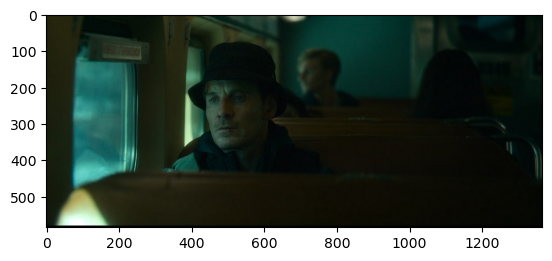

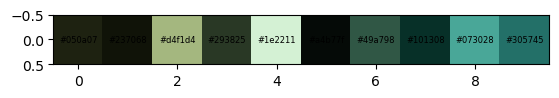

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import colorsys

# Read and preprocess the image
image = mpimg.imread('../killer.jpg')
w, h, d = tuple(image.shape)
pixels = np.reshape(image, (w * h, d))

# Perform KMeans clustering
from sklearn.cluster import KMeans
n_colors = 10
model = KMeans(n_clusters=n_colors,random_state=42).fit(pixels)
palette = np.uint8(model.cluster_centers_)

# Convert RGB colors to HSL and sort by hue
def RGB2HSL(rgb):
    r, g, b = rgb / 255.0
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return [h, l, s]

palette_hsl = [RGB2HSL(color) for color in palette]
palette_sorted = [color for _, color in sorted(zip([hsl[0] for hsl in palette_hsl], palette))]

# Display the image and the sorted color palette
plt.imshow(image)
plt.show()
plt.imshow([palette_sorted])

# Add text labels to the color palette
# Add text labels to the color palette
for i, color in enumerate(palette):
    plt.text(i, 0, RGB2HEX(color), color='black', ha='center', va='center', fontsize=6)

plt.show()


In [32]:
import numpy as np
import plotly.graph_objects as go
from matplotlib.colors import rgb2hex

sample_indices = np.random.choice(np.arange(pixels.shape[0]), size=1000, replace=False)
sampled_pixels = pixels[sample_indices]
points = sampled_pixels  # n points, each with 3 coordinates

# Create a colormap based on RGB values
colors = [rgb2hex(rgb / 255) for rgb in points]

# Format RGB values as strings
rgb_strings = [f"R: {int(rgb[0])}, G: {int(rgb[1])}, B: {int(rgb[2])}" for rgb in points]

# Create a scatter plot with smaller points, colored by RGB values, and RGB values as hover text
fig = go.Figure(data=[go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=3, color=colors),  # Color points based on RGB values
    text=rgb_strings,  # Use RGB values as hover text
)])

# Update layout
fig.update_layout(scene=dict(
    xaxis_title='R',
    yaxis_title='G',
    zaxis_title='B'),
    title='3D Scatter Plot with Smaller Points Colored by RGB Values')

# Show the plot
fig.show()


In [24]:
rgb=cv2.merge([r,g,b])

In [25]:
rgb.reshape(9,3)

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 5]], dtype=int32)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
import cv2
from io import BytesIO

# Read and preprocess the image
img = cv2.imread('These-Mexico-Beaches-Have-Been-Deemed-Unsafe-For-Swimming-Due-To-Contaminated-Water-.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = cv2.resize(img, (240, 240))
w, h, d = tuple(image.shape)
pixels = np.reshape(image, (w * h, d))

# Perform KMeans clustering
from sklearn.cluster import KMeans
n_colors = 10
model = KMeans(n_clusters=n_colors, random_state=42).fit(pixels)
palette = np.uint8(model.cluster_centers_)

# Create a Matplotlib figure with a specified size
fig, ax = plt.subplots(figsize=(8, 2))

# Display the color palette
ax.imshow([palette])

# Add text labels to the color palette
for i, color in enumerate(palette):
    ax.text(i, 0, RGB2HEX(color), color='black', ha='center', va='center', fontsize=8)

# Save the Matplotlib figure to a BytesIO buffer with a specified dpi
buffer = BytesIO()
plt.savefig(buffer, format='png', bbox_inches='tight', pad_inches=0.1, dpi=100)  # Adjust dpi as needed
buffer.seek(0)

# Read the buffer using OpenCV and convert it to an image
palette_image = cv2.imdecode(np.frombuffer(buffer.read(), np.uint8), 1)

# Show the OpenCV image
cv2.imshow('Color Palette', palette_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [3]:
def RGB2HEX(rgb):
    """Convert RGB to hex color code."""
    hex_color = "#{:02x}{:02x}{:02x}".format(rgb[0], rgb[1], rgb[2])
    return hex_color

